# **Comparative Analysis of Bi-LSTM + CRF and BERT for Named Entity Recognition**


---



**Goal:**

The goal of this project is to design, implement and evaluate models for Named Entity Recognition (NER).

Comparing the performance of a traditional Bi-LSTM + CFR model and a modern Transformer-based model (BERT).


**Dataset:**

The CoNLL-2003 dataset one of the most commonly used datasets for NER. This dataset contains annotated text for Named Entity Recognition with entities categorized into four types: Person (PER), Organization (ORG), Location (LOC), and Miscellaneous (MISC).

**Models Used:**
- Bi-LSTM+CRF
- BERT


**Purpose:**
The project aims to provide a comparative study of the effectiveness of traditional and Transformer-based models in performing Named Entity Recognition. The purpose is two fold:

- To assess the precision, recall, and F1-score of each model on the CoNLL-2003 dataset.
- To evaluate the robustness of the models through error analysis and adversarial testing, identifying strengths and weaknesses in different scenarios.


## Setup

In [1]:
!pip install -q tensorflow-addons  # version >= 0.15.0 is required
!pip install -q tensorflow
!pip install -q datasets

ERROR: Invalid requirement: '#'


# Importing packages and libraries

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import datasets
from sklearn.metrics import classification_report
import time

import random
import nltk
from nltk.corpus import wordnet
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Ensure nltk resources are downloaded
nltk.download("wordnet")
nltk.download("omw-1.4")

c:\Users\visha\anaconda3\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
c:\Users\visha\anaconda3\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.12.0 and strictly below 2.15.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.10.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure yo

True

# Loading the data

Loading the CoNLL 2003 dataset by using the datasets library.

In [3]:
conll_data = datasets.load_dataset("conll2003")

# Understaning the structre of the dataset

Inspect the data splits and features:

In [4]:
conll_data

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 14041
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3250
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'chunk_tags', 'ner_tags'],
        num_rows: 3453
    })
})

Get a sample of train data and print it out:

In [5]:
for item in conll_data["train"]:
  sample_tokens = item['tokens']
  sample_tag_ids = item["ner_tags"]
  print(sample_tokens)
  print(sample_tag_ids)
  break

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
[3, 0, 7, 0, 0, 0, 7, 0, 0]


For this Name Entity Recognition model, the input are the tokens which is a list of strings. The outputs are the NER tags which are the tag ids in the dataset.

The dataset also give the information about the mapping of NER tags and ids.

In [6]:
dataset_builder = datasets.load_dataset_builder('conll2003')
raw_tags = dataset_builder.info.features['ner_tags'].feature.names
print(raw_tags)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


Decode the NER tag ids to tags.

In [ ]:
sample_tags = [raw_tags[i] for i in sample_tag_ids]

print(sample_tokens)
print(sample_tags)

['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']


These tags are used to encode the named entities by some format.

In this dataset, tags are encoded in [IOB](https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)) format. A special tag `<PAD>` is added to the tag set which is used to represent a padding in the sequence.

In NLP, 0 is usually used to mark padding. This is the default setting for many functions in Machine Learning software (includes TensorFlow).

Create a list to convert tag ids to tag text.

In [ ]:
tags = ['<PAD>'] + raw_tags
print(tags)

['<PAD>', 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


# Data Preprocessing


**1. Token Lowercasing:**

- Converting all tokens to lowercase using TensorFlow's string operations.
- This step ensures that the model treats "Apple" and "apple" as the same word, which helps in reducing redundancy and improving generalization.

**2. Token Mapping:**

- Tokens are mapped to corresponding indices using a lookup layer.
- This layer converts words into numerical representations that the model can process.

**3. Adjusting Tag IDs:**

- For the NER tags, all tag IDs are incremented by 1.
- This is because a <PAD> tag was added as the first element in the tag list, so all other tags need to shift up by one.

**4. Batching with Padding**

- The dataset is divided into batches of size 2048. Padding is applied to ensure that all sequences in a batch are of the same length.
- This is crucial for efficient processing, as models like BERT require inputs of uniform length.



Define some constants which will be used in later.

In [ ]:
TAG_SIZE = len(tags)
VOCAB_SIZE = 20000

Building vocabulary lookup layer for tokens.

In [10]:
train_tokens = tf.ragged.constant(conll_data["train"]["tokens"])
train_tokens = tf.map_fn(tf.strings.lower, train_tokens)

lookup_layer = tf.keras.layers.StringLookup(max_tokens=VOCAB_SIZE, mask_token="[MASK]", oov_token="[UNK]")
lookup_layer.adapt(train_tokens)

print(len(lookup_layer.get_vocabulary()))
print(lookup_layer.get_vocabulary()[:10])

20000
['[MASK]', '[UNK]', 'the', '.', ',', 'of', 'in', 'to', 'a', 'and']


Creating raw (without preprocess) train and validation dataset.

In [11]:
def create_data_generator(dataset):
    """
    Creates a generator function for the dataset.

    Args:
        dataset (list): List of dictionaries containing 'tokens' and 'ner_tags'.

    Returns:
        function: A generator function that yields tokens and their corresponding NER tags.
    """
    def data_generator():
        # Yield each item in the dataset as (tokens, ner_tags)
        for item in dataset:
            yield item['tokens'], item['ner_tags']

    return data_generator

# Define the output signature for the data generator
data_signature = (
    tf.TensorSpec(shape=(None,), dtype=tf.string),  # Tokens are strings
    tf.TensorSpec(shape=(None,), dtype=tf.int32)   # NER tags are integers
)

# Create a TensorFlow Dataset for the training data
train_data = tf.data.Dataset.from_generator(
    create_data_generator(conll_data["train"]),  # Pass training data to generator
    output_signature=data_signature  # Specify output structure
)

Creating train and validation dataset that can be used for traning and validation.

In [12]:
def dataset_preprocess(tokens, tag_ids):
    """
    Preprocesses tokens and adjusts tag IDs for the dataset.

    Args:
        tokens (list): List of input tokens.
        tag_ids (np.array or list): Array or list of NER tag IDs.

    Returns:
        tuple: Preprocessed tokens and adjusted tag IDs.
    """
    # Preprocess the tokens (e.g., lowercasing, token cleaning)
    preprocessed_tokens = preprecess_tokens(tokens)

    # Increment all tag IDs by 1 since `<PAD>` is added as the first tag
    preprocessed_tag_ids = tag_ids + 1

    return preprocessed_tokens, preprocessed_tag_ids


In [13]:
def preprecess_tokens(tokens):
    """
    Converts tokens to lowercase and maps them to corresponding indices.

    Args:
        tokens (tf.Tensor): A tensor of input tokens.

    Returns:
        tf.Tensor: Preprocessed tokens mapped through the lookup layer.
    """
    # Convert tokens to lowercase
    tokens = tf.strings.lower(tokens)
    # Map tokens using the lookup layer
    return lookup_layer(tokens)

# Set the batch size for training
BATCH_SIZE = 2048

# Create the training dataset pipeline
train_dataset = (
    train_data.map(dataset_preprocess)  # Apply preprocessing to the dataset
    .padded_batch(batch_size=BATCH_SIZE)  # Batch data with padding
    .cache()  # Cache the dataset in memory for faster access
)


## **Model Architecture**

**Embedding Layer:**

Converts integer word indices (input tokens) into dense vector representations, capturing semantic information about each word.

**Bi-LSTM Layer:**
Processes the embeddings bidirectionally, capturing contextual information from both preceding and succeeding tokens.
Outputs a sequence of hidden states for all input tokens.

**CRF Layer:**
Predicts the most likely sequence of labels for the given inputs by enforcing valid label transitions.
Learns transition probabilities between labels, allowing it to model dependencies.

**Outputs:**
decode_sequence: Predicted sequence of labels for the input tokens.
potentials, sequence_length, and kernel: Internal variables used for computing the loss.

### Creating model

In [14]:
def build_embedding_bilstm_crf_model(
    vocab_size: int, embed_dims: int, lstm_unit: int, tag_size: int
) -> tf.keras.Model:
    """
    Builds a BiLSTM-CRF model for sequence labeling tasks.

    Args:
        vocab_size (int): Size of the vocabulary.
        embed_dims (int): Dimensions for the embedding layer.
        lstm_unit (int): Number of units in the LSTM layer.
        tag_size (int): Number of tags for classification.

    Returns:
        tf.keras.Model: A compiled BiLSTM-CRF model.
    """
    # Input layer for token sequences
    x = tf.keras.layers.Input(shape=(None,), dtype=tf.int32, name="x")

    # Embedding layer to convert tokens into dense vector representations
    y = tf.keras.layers.Embedding(vocab_size, embed_dims, mask_zero=True)(x)

    # BiLSTM layer to capture contextual information from both directions
    y = tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(lstm_unit, return_sequences=True)
    )(y)

    # CRF layer for sequence decoding and tagging
    decode_sequence, potentials, sequence_length, kernel = tfa.layers.CRF(tag_size)(y)

    # Return the complete model
    return tf.keras.Model(
        inputs=x, outputs=[decode_sequence, potentials, sequence_length, kernel]
    )

# Build the BiLSTM-CRF model with specified parameters
model = build_embedding_bilstm_crf_model(VOCAB_SIZE, 32, 64, TAG_SIZE)

In [15]:
total_parameters = model.count_params()
print(f"Total Trainable Parameters: {total_parameters}")

Total Trainable Parameters: 691074


Run the model on a single batch of data, and inspect the output:

In [16]:
# preprocess
preprecessd_tokens = preprecess_tokens(sample_tokens)

# expand the tensor to shape: [1, None]. That is add batch dim
inputs = tf.expand_dims(preprecessd_tokens, axis=0)

outputs, *_ = model(inputs)
print(outputs[0])

tf.Tensor([0 9 3 5 2 6 0 9 3], shape=(9,), dtype=int32)


### Define CRF loss function

By using the real y and some internal variables of the CRF layer. You can compute the log likelihood of real y. Use the negative of log likelihood as the loss to optimize.

In [17]:
@tf.function
def crf_loss_func(potentials, sequence_length, kernel, y):
    """
    Computes the CRF loss function using the log likelihood of the CRF.

    Args:
        potentials (tf.Tensor): The potential scores from the CRF layer.
        sequence_length (tf.Tensor): The sequence lengths for each batch.
        kernel (tf.Tensor): The CRF kernel.
        y (tf.Tensor): The true labels (ground truth).

    Returns:
        tf.Tensor: The mean CRF loss.
    """
    # Compute the CRF log likelihood (negative log-likelihood)
    crf_likelihood, _ = tfa.text.crf_log_likelihood(
        potentials, y, sequence_length, kernel
    )

    # Convert likelihood to loss by negating the likelihood
    flat_crf_loss = -1 * crf_likelihood

    # Compute mean loss across all sequences in the batch
    crf_loss = tf.reduce_mean(flat_crf_loss)

    return crf_loss

### Define optimizer, metrics and train_step fucntion

The Bi-LSTM-CRF model was trained with a large batch size of 2048 to efficiently process the dataset. The Adam optimizer, with its default learning rate of 0.02, was employed for adaptive gradient updates, facilitating faster convergence.

In [18]:
# Define the optimizer (Adam with learning rate 0.02)
optimizer = tf.keras.optimizers.Adam(0.02)

# Track the mean training loss
train_loss = tf.keras.metrics.Mean(name="train_loss")

@tf.function(experimental_relax_shapes=True)
def train_step(x, y):
    """
    Performs one step of training, computes the CRF loss, and updates model weights.

    Args:
        x (tf.Tensor): The input data (token sequences).
        y (tf.Tensor): The true labels (ground truth NER tags).
    """
    with tf.GradientTape() as tape:
        # Forward pass: Get model outputs (decoded sequence, potentials, etc.)
        decoded_sequence, potentials, sequence_length, kernel = model(x)

        # Compute CRF loss using the model's outputs and true labels
        crf_loss = crf_loss_func(potentials, sequence_length, kernel, y)

        # Total loss: CRF loss + any other model-specific losses
        loss = crf_loss + tf.reduce_sum(model.losses)

    # Compute gradients with respect to the loss
    grads = tape.gradient(loss, model.trainable_variables)

    # Apply gradients to update the model's weights
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Update the running mean of the training loss
    train_loss(loss)

### Training model

The training was conducted over 10 epochs, providing the model with sufficient iterations to learn from the data. While dropout regularization was not explicitly applied, it could enhance generalization in future implementations. Early stopping criteria were not used, and the model trained for the full number of epochs as predefined.

In [19]:
EPOCHS = 10

for epoch in range(EPOCHS):
    start=time.time()
    # Reset the metrics at the start of the next epoch
    train_loss.reset_states()

    for x, y in train_dataset:
        train_step(x, y)
    print(f"Epoch {epoch + 1}, " f"Loss: {train_loss.result()}")
    print("Time taken for 1 epoch: {} secs\n".format(time.time() - start))


Epoch 1, Loss: 15.345284461975098
Time taken for 1 epoch: 30.140800714492798 secs

Epoch 2, Loss: 7.7888078689575195
Time taken for 1 epoch: 1.2570362091064453 secs

Epoch 3, Loss: 5.116799831390381
Time taken for 1 epoch: 1.2063977718353271 secs

Epoch 4, Loss: 3.4540677070617676
Time taken for 1 epoch: 1.2531530857086182 secs

Epoch 5, Loss: 2.080608367919922
Time taken for 1 epoch: 1.2124273777008057 secs

Epoch 6, Loss: 1.2469475269317627
Time taken for 1 epoch: 1.2941789627075195 secs

Epoch 7, Loss: 0.8509308099746704
Time taken for 1 epoch: 1.3628931045532227 secs

Epoch 8, Loss: 0.628504753112793
Time taken for 1 epoch: 1.329214334487915 secs

Epoch 9, Loss: 0.48368507623672485
Time taken for 1 epoch: 1.2998967170715332 secs

Epoch 10, Loss: 0.3897568881511688
Time taken for 1 epoch: 1.2530207633972168 secs



### Making inference

Inspect the predict result.

In [20]:
# displaying the inputs and expected outputs
print("raw inputs: ", sample_tokens)

# preprocess
preprocessed_inputs = preprecess_tokens(
    sample_tokens
)

inputs = tf.reshape(preprocessed_inputs, shape=[1, -1])

outputs, *_ = model.predict(inputs)
prediction = [tags[i] for i in outputs[0]]

# Keypoint: EU -> B-ORG, German -> B-MISC, British -> B-MISC
print("ground true tags: ", sample_tags)
print("predicted tags: ", prediction)
print(outputs[0])

raw inputs:  ['EU', 'rejects', 'German', 'call', 'to', 'boycott', 'British', 'lamb', '.']
1/1 [==============================] - 3s 3s/step
ground true tags:  ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
predicted tags:  ['B-ORG', 'O', 'B-MISC', 'O', 'O', 'O', 'B-MISC', 'O', 'O']
[4 1 8 1 1 1 8 1 1]


In [21]:
test_tokens = []
test_tags_ids = []
test_tags = []
for item in conll_data["test"]:
  test_tokens = test_tokens+item['tokens']
  test_tags_ids = test_tags_ids+item['ner_tags']

for i in test_tags_ids:
  test_tags.append(raw_tags[i])

preprocessed_inputs = preprecess_tokens(
    test_tokens
)

inputs = tf.reshape(preprocessed_inputs, shape=[1, -1])

outputs, *_ = model.predict(inputs)
prediction = []
for i in outputs[0]:
  prediction.append(tags[i])

print("ground true tags: ", test_tags)
print("predicted tags: ", prediction)

1/1 [==============================] - 44s 44s/step
ground true tags:  ['O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'B-PER', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'B-LOC', 'O', 'B-LOC', 'I-LOC', 'I-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-LOC', 'O', 'B-LOC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-PER', 'I-PER', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'I-MISC', 'O', 'O', 'O', 'O', 'O', 'B-LO

In [22]:
print(classification_report(test_tags, prediction))

              precision    recall  f1-score   support

       B-LOC       0.80      0.81      0.80      1668
      B-MISC       0.78      0.70      0.74       702
       B-ORG       0.88      0.45      0.59      1661
       B-PER       0.88      0.50      0.64      1617
       I-LOC       0.73      0.62      0.67       257
      I-MISC       0.56      0.50      0.53       216
       I-ORG       0.82      0.33      0.47       835
       I-PER       0.88      0.25      0.39      1156
           O       0.92      1.00      0.96     38323

    accuracy                           0.91     46435
   macro avg       0.81      0.57      0.64     46435
weighted avg       0.91      0.91      0.90     46435



In [23]:
# Original sentences (from CoNLL dataset or similar for demonstration)
original_sentences = [
    "Barack Obama was born in Honolulu, Hawaii.",
    "Apple Inc. is based in Cupertino, California.",
    "The Eiffel Tower is located in Paris.",
    "Cristiano Ronaldo scored a goal for Portugal.",
    "Tesla manufactures electric cars in California.",
    "Google was founded by Larry Page and Sergey Brin.",
    "Microsoft announced a new product yesterday.",
    "Amazon's headquarters are in Seattle, Washington.",
    "The Prime Minister met with the President of France.",
    "The Grand Canyon is a major tourist attraction in Arizona."
]

In [24]:
# Define a function for synonym replacement as an adversarial transformation
def synonym_replacement(sentence):
    """
    Replaces a random word in the sentence with one of its synonyms.

    Args:
        sentence (str): The input sentence to be transformed.

    Returns:
        str: The sentence with one word replaced by its synonym.
    """
    # Split the sentence into words
    words = sentence.split()

    # Randomly select a word to replace
    word_to_replace = random.choice(words)

    # Get synonyms for the selected word from WordNet
    synonyms = wordnet.synsets(word_to_replace)

    # If synonyms exist, replace the word with the first synonym found
    if synonyms:
        synonym = synonyms[0].lemmas()[0].name()
        # Ensure the synonym is different from the original word
        if synonym != word_to_replace:
            words[words.index(word_to_replace)] = synonym

    # Return the modified sentence
    return " ".join(words)

In [25]:
# Define a function to introduce a random typo in a sentence
def introduce_typo(sentence):
    """
    Introduces a random typo in a randomly selected word in the sentence.

    Args:
        sentence (str): The input sentence to be transformed.

    Returns:
        str: The sentence with one word modified to introduce a typo.
    """
    # Split the sentence into words
    words = sentence.split()

    # Randomly select a word to introduce a typo
    word_to_typo = random.choice(words)

    # If the word is longer than one character, introduce a typo
    if len(word_to_typo) > 1:
        typo = list(word_to_typo)
        # Replace a random character in the word with a random letter
        typo[random.randint(0, len(typo)-1)] = random.choice("abcdefghijklmnopqrstuvwxyz")
        # Update the word in the sentence
        words[words.index(word_to_typo)] = "".join(typo)

    # Return the modified sentence
    return " ".join(words)

In [26]:
# Define a function to swap named entities in a sentence
def entity_swapping(sentence):
    """
    Swaps predefined entities in the sentence with other entities.

    Args:
        sentence (str): The input sentence containing named entities.

    Returns:
        str: The sentence with entities swapped if found.
    """
    # List of original entities and their corresponding replacements
    entities = ["Barack Obama", "Honolulu", "Apple Inc.", "Cupertino", "Paris",
                "Cristiano Ronaldo", "Tesla", "Google", "Microsoft", "Seattle"]
    replacements = ["Joe Biden", "Kailua", "Google", "Mountain View", "London",
                    "Lionel Messi", "Lucid", "Facebook", "Amazon", "Portland"]

    # Loop through entities and their replacements
    for original, replacement in zip(entities, replacements):
        # If the original entity is found, replace it with the corresponding replacement
        if original in sentence:
            return sentence.replace(original, replacement)

    # Return the sentence unchanged if no entity is found
    return sentence

In [27]:
# Generate adversarial examples
adversarial_pairs = []
for sentence in original_sentences:
    transformation = random.choice([synonym_replacement, introduce_typo, entity_swapping])
    adversarial_sentence = transformation(sentence)
    adversarial_pairs.append((sentence, adversarial_sentence))

# Display results
for original, adversarial in adversarial_pairs:
    print(f"Original: {original}")
    print(f"Adversarial: {adversarial}")
    print()


Original: Barack Obama was born in Honolulu, Hawaii.
Adversarial: Joe Biden was born in Honolulu, Hawaii.

Original: Apple Inc. is based in Cupertino, California.
Adversarial: Apple Inc. is based inch Cupertino, California.

Original: The Eiffel Tower is located in Paris.
Adversarial: The Eiffel Tower be located in Paris.

Original: Cristiano Ronaldo scored a goal for Portugal.
Adversarial: Cristiano Ronaldo scored a goal for Portujal.

Original: Tesla manufactures electric cars in California.
Adversarial: Lucid manufactures electric cars in California.

Original: Google was founded by Larry Page and Sergey Brin.
Adversarial: Google was foundes by Larry Page and Sergey Brin.

Original: Microsoft announced a new product yesterday.
Adversarial: Microsoft announced a new iroduct yesterday.

Original: Amazon's headquarters are in Seattle, Washington.
Adversarial: Amazon's headquarters are in Seattle, Washington.

Original: The Prime Minister met with the President of France.
Adversarial: T

In [28]:
test_tokens = []
test_tags = []
for original, adversarial in adversarial_pairs:
  test_tokens = test_tokens+adversarial.split()


preprocessed_inputs = preprecess_tokens(
    test_tokens
)

inputs = tf.reshape(preprocessed_inputs, shape=[1, -1])

outputs, *_ = model.predict(inputs)
prediction = []
for i in outputs[0]:
  prediction.append(tags[i])

for token , tag in zip(test_tokens, prediction):
  print(f"Token: {token}, Predicted Tag: {tag}")

1/1 [==============================] - 0s 211ms/step
Token: Joe, Predicted Tag: B-PER
Token: Biden, Predicted Tag: O
Token: was, Predicted Tag: O
Token: born, Predicted Tag: O
Token: in, Predicted Tag: O
Token: Honolulu,, Predicted Tag: O
Token: Hawaii., Predicted Tag: O
Token: Apple, Predicted Tag: B-ORG
Token: Inc., Predicted Tag: I-ORG
Token: is, Predicted Tag: O
Token: based, Predicted Tag: O
Token: inch, Predicted Tag: O
Token: Cupertino,, Predicted Tag: O
Token: California., Predicted Tag: O
Token: The, Predicted Tag: O
Token: Eiffel, Predicted Tag: O
Token: Tower, Predicted Tag: O
Token: be, Predicted Tag: O
Token: located, Predicted Tag: O
Token: in, Predicted Tag: O
Token: Paris., Predicted Tag: O
Token: Cristiano, Predicted Tag: O
Token: Ronaldo, Predicted Tag: B-PER
Token: scored, Predicted Tag: O
Token: a, Predicted Tag: O
Token: goal, Predicted Tag: O
Token: for, Predicted Tag: O
Token: Portujal., Predicted Tag: O
Token: Lucid, Predicted Tag: O
Token: manufactures, Predict

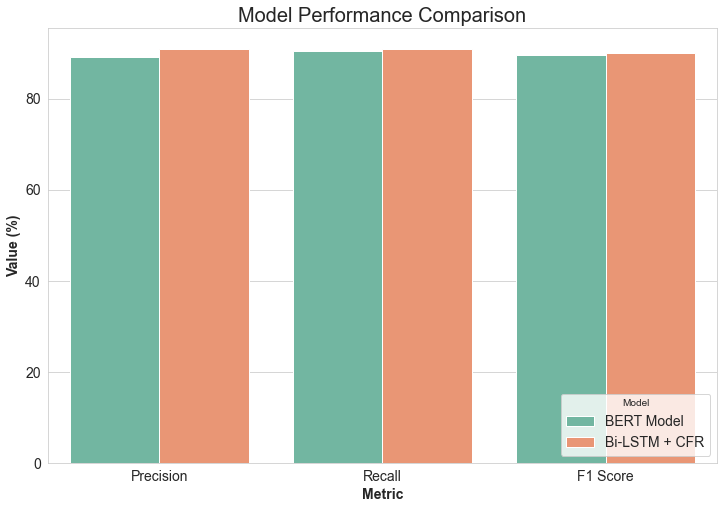

In [29]:
# Define the results
models = ['BERT Model', 'Bi-LSTM + CFR']
precision = [89.07, 91]
recall = [90.5, 91]
f1_score = [89.7, 90]

# Create a DataFrame with the data
df = pd.DataFrame({
    'Model': models,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1_score
})
df_melted = pd.melt(df, id_vars='Model', value_vars=['Precision', 'Recall', 'F1 Score'])

# Grouped bar chart
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(12, 8))  # Increase the figure size
sns.barplot(x='variable', y='value', hue='Model', data=df_melted, palette='Set2', ax=ax)

# Setting the title and labels
ax.set_title('Model Performance Comparison', fontsize=20)
ax.set_xlabel('Metric', fontsize=14, fontweight='bold')
ax.set_ylabel('Value (%)', fontsize=14, fontweight='bold')

ax.tick_params(axis='both', labelsize=14)

# Add a legend
ax.legend(title='Model', fontsize=14,loc="lower right")

# Show the plot
plt.show()